In [1]:
%pip install "numpy<=2.2"
%pip install --upgrade meshio scipy
# Install compatible versions to avoid holoviews collections.Iterable issue
%pip install "holoviews>=1.15.0" "param>=1.12.0"
%pip install --upgrade uxarray rioxarray

import os
import sys
sys.path.append('.')
import meshio
import numpy as np
import xarray as xr
import uxarray as uxr
import rioxarray as xrio
from scipy.spatial import Delaunay

# On Docker turn off the warning on PROJ by specifying the PROJ lib path (uncomment the following line)
#os.environ['PROJ_LIB'] = '/opt/conda/envs/gospl/share/proj'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scripts import umeshFcts as ufcts

# Create a replacement for meshplex functionality
class MeshTriAlternative:
    def __init__(self, vertices, cells):
        self.vertices = vertices
        self.cells = cells
        self.control_volumes = self._compute_control_volumes()
    
    def _compute_control_volumes(self):
        """Compute control volumes (areas) for each vertex using Voronoi-like approach"""
        n_vertices = len(self.vertices)
        volumes = np.zeros(n_vertices)
        
        # For each triangle, distribute 1/3 of its area to each vertex
        for cell in self.cells:
            # Get the three vertices of the triangle
            v0, v1, v2 = self.vertices[cell[0]], self.vertices[cell[1]], self.vertices[cell[2]]
            
            # Calculate triangle area using cross product
            area = 0.5 * abs(np.cross(v1 - v0, v2 - v0))
            
            # Distribute area equally to the three vertices
            for vertex_idx in cell:
                volumes[vertex_idx] += area / 3.0
        
        return volumes

# Monkey patch to replace meshplex
import sys
class MockMeshplex:
    @staticmethod
    def MeshTri(vertices, cells):
        return MeshTriAlternative(vertices, cells)

sys.modules['meshplex'] = MockMeshplex()

import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/5.9 MB ? eta -:--:--  Downloading uc_micro_py-1.0.3-py3-none-any.whl.metadata (2.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/29.5 MB ? eta -:--:--Downloading panel-1.7.5-py3-none-any.whl (29.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 86.9 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 86.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.6 MB/s  0:00:00
  Attempting uninsta

# Create a mesh from scratch

In cases where one to make some generic models, you could build your input file directly in many ways. 

Here is a simple example where we define a flat elevation at 100 m and a simple tectonic uplift (with a linear slope ranging to 5 mm/yr) and export it to a goSPL input file.

<xarray.Dataset> Size: 4MB
Dimensions:    (x: 501, y: 501)
Coordinates:
  * x          (x) float64 4kB 0.0 200.0 400.0 600.0 ... 9.96e+04 9.98e+04 1e+05
  * y          (y) float64 4kB 0.0 100.0 200.0 300.0 ... 4.98e+04 4.99e+04 5e+04
Data variables:
    elev       (y, x) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cellwidth  (y, x) float64 2MB 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0

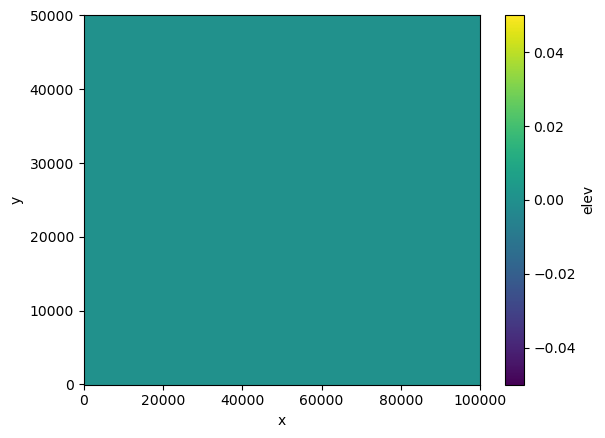

In [18]:
dx = 200 # desired resolution
nx = 501 # desired number of nodes along the x-axis
ny = 501 # desired number of nodes along the y-axis
xdim = 1.0e5 # 100 km
ydim = 0.5e5 #  50 km
tmin = 0.
tmax = 0.005

xcoords = np.linspace(0,xdim,nx)
ycoords = np.linspace(0,ydim,ny)
X, Y = np.meshgrid(xcoords, ycoords)
# xcoords = np.arange(nx)*float(dx) 
# ycoords = np.arange(ny)*float(dx) 
# tecx = np.interp(xcoords, [xcoords[0],xcoords[-1]], [tmin,tmax])
# tec = np.broadcast_to(tecx, (nx, nx))[:ny,:]

elev = np.zeros_like(X)
# noise = np.random.normal(0, 0.05, tec.shape)
# elev = noise+100.

ds = xr.Dataset({
    'elev': xr.DataArray(
                data   = elev,
                dims   = ['y','x'],
                coords = {'x': xcoords,'y': ycoords},
    ),
    # 'tec': xr.DataArray(
    #             data   = tec,
    #             dims   = ['y','x'],
    #             coords = {'x': xcoords,'y': ycoords},
    #             )
    }
    )
ds['cellwidth'] = (['y','x'],dx*np.ones( (ny, nx)))
ds.elev.plot()
ds


We then build the unstructured grid for running goSPL

In [19]:
output_path = "coupling_test" 
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Build your planar mesh
ufcts.planarMesh(ds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)


Running: jigsaw coupling_test/mesh2D.jig
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = coupling_test/mesh2D.msh 
  MESH-FILE = coupling_test/mesh2D-MESH.msh 
  HFUN-FILE = coupling_test/mesh2D-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ET

Build time indices:   0% |                                     | ETA:  --:--:--
Build time indices: 100% |#####################################| ETA:  00:00:00
Build time indices: 100% |#####################################| Time:  0:00:00


maxEdges=
nVertLevels=
nParticles=

Extracting a total of 1 time levels.
Using file 'coupling_test/base2D.nc' as the mesh file for this extraction.


The following variables will be extracted from the input file(s).

   Variables with 'nCells' as a dimension:
      name: areaCell

 -- Extracting cell fields --
Build geometry for fields on cells...


Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series: 100% |####################################| Time:  0:00:00


The mesh (`base2D.nc`) is now stored in the output folder (here named `coupling_test`). 

We will open this file and extract the information used in goSPL:

We now read the created `vtk` file and add the interpolated variables to it:

In [27]:
mesh = meshio.read(output_path+'/planar.vtk')
vertex = mesh.points
cells = mesh.cells_dict['triangle']

### Creating goSPL input

We will now create the inputs for goSPL. We first start by creating the input mesh defining our UGRID structure:

In [28]:
meshname = output_path+"/gospl_mesh"
np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=np.zeros_like(vertex)
                    )